In [1]:
%load_ext watermark
%watermark -p tensorflow,skimage,matplotlib,numpy,random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
from random import shuffle
from tqdm import tqdm

from skimage import data, io, filters
from skimage import transform
from skimage import data

# ### CPU ONLY SESSION
# ###################################################################
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = ""
# ###################################################################

import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.preprocessing.image import ImageDataGenerator


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dropout

#for the pretrained model
from keras.applications import ResNet50
from keras.layers import GlobalAveragePooling2D
from keras.applications.resnet50 import preprocess_input

from keras.models import load_model
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from keras import regularizers


# FOR GPU session
# from keras.backend.tensorflow_backend import set_session
# config = tf.ConfigProto(log_device_placement=True)
# config.gpu_options.allow_growth = True
# set_session(tf.Session(config=config))

C:\Users\Anca\Anaconda3\envs\tensorflow-cpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


tensorflow 1.7.0
skimage 0.13.1
matplotlib 2.2.2
numpy 1.14.2
random n


Using TensorFlow backend.


In [2]:
train_dir = '../monkeyDataset/training'
validate_dir = '../monkeyDataset/validation'

cols = ['Label','Latin Name', 'Common Name','Train Images', 'Validation Images']
infoFile = pd.read_csv("../monkeyDataset/monkey_labels.txt", names=cols, skiprows=1)
infoFile

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


In [3]:
train_dir = '../monkeyDataset/training'
validate_dir = '../monkeyDataset/validation'

# for the convolutional network, we get help from: http://www.cs.ucc.ie/~dgb/courses/ai2/14_convnet_example.pdf
train_data_generator = ImageDataGenerator(rescale=1./255)
train_generator = train_data_generator.flow_from_directory(
    train_dir, target_size=(150,150), batch_size=20, class_mode="categorical")

val_data_generator = ImageDataGenerator(rescale=1./255)
val_generator = val_data_generator.flow_from_directory(
    validate_dir, target_size=(150,150), batch_size=20, class_mode="categorical")


Found 1097 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [4]:
def build_convnet():
    network = Sequential()
    network.add(Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3)))
    network.add(MaxPooling2D((2, 2)))
    network.add(Conv2D(64, (3, 3), activation="relu"))
    network.add(MaxPooling2D((2, 2)))
    network.add(Conv2D(128, (3, 3), activation="relu"))
    network.add(MaxPooling2D((2, 2)))
    network.add(Conv2D(128, (3, 3), activation="relu"))
    network.add(MaxPooling2D((2, 2)))
    network.add(Flatten())
    network.add(Dense(512, activation="relu"))
    network.add(Dense(10, activation="softmax"))
    network.compile(optimizer=RMSprop(lr=0.0003), loss="categorical_crossentropy", metrics=["accuracy"])
    return network

network = build_convnet()
network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [8]:
# run model with no early stopping => it carries on learning for 30 epochs
# history = network.fit_generator(
#     train_generator, steps_per_epoch=54, epochs=30,
#     validation_data=val_generator, validation_steps=13,
#     verbose=0)

# train_loss = history.history["loss"]
# val_loss = history.history["val_loss"]

# x_vals = range(1, 31)
# fig = plt.figure()
# plt.title("Loss")
# plt.plot(x_vals, train_loss, label="Training loss", color = "purple")
# plt.plot(x_vals, val_loss, label="Validation loss", color = "orange")
# plt.legend()
# plt.show()

# train_acc = history.history["acc"]
# val_acc = history.history["val_acc"]

# fig = plt.figure()
# plt.title("Accuracy")
# plt.plot(x_vals, train_acc, label="Training accuracy", color = "purple")
# plt.plot(x_vals, val_acc, label="Validation accuracy", color = "orange")
# plt.legend()
# plt.show()

In [5]:
# we set the param patience=2 to have an early stopping <=>  interrupts training when 
# the loss has stopped improving for more than two epochs
history = network.fit_generator(
    train_generator, steps_per_epoch=100, epochs=30,
    validation_data=val_generator, validation_steps=50,
    callbacks=[EarlyStopping(monitor="val_loss", patience=2)],
    verbose=0)

We can see that the model stopped training after epoches = 8


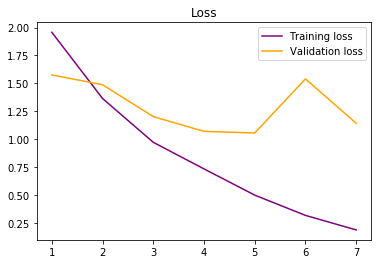

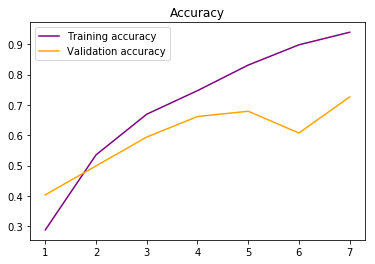

In [41]:
# plot loss and accuracy for early stopping
results = history.history
no_epochs_runned= len(results["acc"]) + 1 
print("We can see that the model stopped training after epoches =", no_epochs_runned)

train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
 
x_vals = range(1, no_epochs_runned)
fig = plt.figure()
plt.title("Loss")
plt.plot(x_vals, train_loss, label="Training loss", color = "purple")
plt.plot(x_vals, val_loss, label="Validation loss", color = "orange")
plt.legend()
plt.show()

train_acc = history.history["acc"]
val_acc = history.history["val_acc"]

fig = plt.figure()
plt.title("Accuracy")
plt.plot(x_vals, train_acc, label="Training accuracy", color = "purple")
plt.plot(x_vals, val_acc, label="Validation accuracy", color = "orange")
plt.legend()
plt.show()


In [42]:
# Since patience was 2, perhaps display the metrics from just before that point
train_loss = history.history["loss"][-3]
val_loss = history.history["val_loss"][-3]
train_acc = history.history["acc"][-3]
val_acc = history.history["val_acc"][-3]

print("Train loss=",train_loss)
print("Validation loss=",val_loss)
print("Train accuracy=", train_acc)
print("Validation accuracy", val_acc)

Train loss= 0.49775741956268654
Validation loss= 1.0548049360513687
Train accuracy= 0.831494484526463
Validation accuracy 0.6793032788106652


<p dir="ltr"><span style="font-size: 20pt;"><strong>Overcome the overfitting problem</strong></span></p>
<p dir="ltr"><span style="font-size: 14pt;">Firstly, apply data argumentation on the training set to increase the number of training examples.&nbsp;</span></p>
<p dir="ltr"><span style="font-size: 14pt;">Exemplify the following strategies for overcoming the overfitting problem in the case of networks:</span></p>
<p dir="ltr"><span style="font-size: 14pt;">1. Weight Regularization</span></p>
<p dir="ltr"><span style="font-size: 14pt;">2. Dropout</span></p>

 <p dir="ltr"><span style="font-size: 24px;"><strong>Data argumentation</strong></span></p>

In [28]:
# as we have very few examples, we use data augumentation <=> synthetically create new examples in the trainset
# of the classes using image transformations
augmented_train_data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,                 # degree range for random rotations
    width_shift_range=0.2,             # range for random horizontal shifts
    height_shift_range=0.2,            # range for random vertical shifts
    zoom_range=0.2,                    # range for random zoom
    horizontal_flip=True,              # randomly, whether to flip inputs horizontally
    fill_mode="nearest")               #  the strategy for filling-in newly created pixels that appear
                                       # after some of the other transformations

augumented_train_generator = augmented_train_data_generator.flow_from_directory(
    train_dir, target_size=(150,150), batch_size=20, class_mode="categorical")

Found 1097 images belonging to 10 classes.


 <p dir="ltr"><span style="font-size: 24px;"><strong>Weight Regularization</strong></span></p>

In [47]:
def build_regulated_convnet():
    network = Sequential()
    network.add(Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3)))
    network.add(MaxPooling2D((2, 2)))
    network.add(Conv2D(64, (3, 3), activation="relu", kernel_regularizer=regularizers.l2(0.01)))
    network.add(MaxPooling2D((2, 2)))
    network.add(Conv2D(128, (3, 3), activation="relu", kernel_regularizer=regularizers.l2(0.01)))
    network.add(MaxPooling2D((2, 2)))
    network.add(Conv2D(128, (3, 3), activation="relu", kernel_regularizer=regularizers.l2(0.01)))
    network.add(MaxPooling2D((2, 2)))
    network.add(Flatten())
    network.add(Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.01)))
    network.add(Dense(10, activation="softmax", kernel_regularizer=regularizers.l2(0.01)))
    network.compile(optimizer=RMSprop(lr=0.0003), loss="categorical_crossentropy", metrics=["accuracy"])
    return network

regulated_network = build_regulated_convnet()
regulated_network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 15, 15, 128)       147584    
__________

In [34]:
history = regulated_network.fit_generator(
    train_generator, steps_per_epoch=54, epochs=30,
    validation_data=val_generator, validation_steps=13,
    callbacks=[EarlyStopping(monitor="val_loss", patience=2)],
    verbose=0)

results = history.history
no_epochs_runned= len(results["acc"]) + 1 
print("We can see that the model stopped training after epoches =", no_epochs_runned)

# Since patience was 2, perhaps display the metrics from just before that point
train_loss = history.history["loss"][-3]
val_loss = history.history["val_loss"][-3]
train_acc = history.history["acc"][-3]
val_acc = history.history["val_acc"][-3]

print("Using the original dataset:")
print("Train loss=",train_loss)
print("Validation loss=",val_loss)
print("Train accuracy=", train_acc)
print("Validation accuracy", val_acc)

We can see that the model stopped training after epoches = 7
Using the original dataset:
Train loss= 1.2881495633839248
Validation loss= 1.4369028950812386
Train accuracy= 0.6925388080332359
Validation accuracy 0.6270491794728842


In [31]:
history = regulated_network.fit_generator(
    augumented_train_generator, steps_per_epoch=54, epochs=30,
    validation_data=val_generator, validation_steps=13,
    callbacks=[EarlyStopping(monitor="val_loss", patience=2)],
    verbose=0)

results = history.history
no_epochs_runned= len(results["acc"]) + 1 
print("We can see that the model stopped training after epoches =", no_epochs_runned)

# Since patience was 2, perhaps display the metrics from just before that point
train_loss = history.history["loss"][-3]
val_loss = history.history["val_loss"][-3]
train_acc = history.history["acc"][-3]
val_acc = history.history["val_acc"][-3]

print("Using the argumented dataset:")
print("Train loss=",train_loss)
print("Validation loss=",val_loss)
print("Train accuracy=", train_acc)
print("Validation accuracy", val_acc)

We can see that the model stopped training after epoches = 13
Train loss= 1.8098891774713544
Validation loss= 1.606824568060578
Train accuracy= 0.4776494233887259
Validation accuracy 0.5809426223401164


 <p dir="ltr"><span style="font-size: 24px;"><strong>Dropout</strong></span></p>

In [58]:
def build_dropout_convnet():
    network = Sequential()
    network.add(Conv2D(32, (3, 3), activation="relu", input_shape=(150,150, 3)))
    network.add(MaxPooling2D((2, 2)))
    network.add(Conv2D(64, (3, 3), activation="relu"))
    network.add(MaxPooling2D((2, 2)))
    network.add(Conv2D(128, (3, 3), activation="relu"))
    network.add(MaxPooling2D((2, 2)))
    network.add(Conv2D(128, (3, 3), activation="relu"))
    network.add(MaxPooling2D((2, 2)))
    network.add(Flatten())
    network.add(Dropout(0.5))
    network.add(Dense(512, activation="relu"))
    network.add(Dense(10, activation="softmax", kernel_regularizer=regularizers.l2(0.01)))
    network.compile(optimizer=RMSprop(lr=0.0003), loss="categorical_crossentropy", metrics=["accuracy"])
    return network

dropout_network = build_dropout_convnet()
dropout_network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 15, 15, 128)       147584    
__________

In [59]:
history = dropout_network.fit_generator(
    train_generator, steps_per_epoch=54, epochs=30,
    validation_data=val_generator, validation_steps=13,
    callbacks=[EarlyStopping(monitor="val_loss", patience=2)],
    verbose=0)

results = history.history
no_epochs_runned= len(results["acc"]) + 1 
print("We can see that the model stopped training after epoches =", no_epochs_runned)

# Since patience was 2, perhaps display the metrics from just before that point
train_loss = history.history["loss"][-3]
val_loss = history.history["val_loss"][-3]
train_acc = history.history["acc"][-3]
val_acc = history.history["val_acc"][-3]

print("Using the original dataset:")
print("Train loss=",train_loss)
print("Validation loss=",val_loss)
print("Train accuracy=", train_acc)
print("Validation accuracy", val_acc)

We can see that the model stopped training after epoches = 18
Using the original dataset:
Train loss= 0.5420499211549759
Validation loss= 1.043389352468344
Train accuracy= 0.8549999964237213
Validation accuracy 0.7000000041264755


 <p dir="ltr"><span style="font-size: 24px;"><strong>Transfer Learning</strong></span></p>

In [6]:
# take pretrained network's weights without its last layer's weights (notop)
resnet_weights_path = '../pretrainedWeights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

from_pretrained_network = Sequential()

# add the pretrained model as first layer, include_top= False determines the exclusion of the last layer of the model
# (the classification layer in the original pretrained classes)
from_pretrained_network.add(ResNet50(include_top=False, pooling='avg', weights=resnet_weights_path))

# add to the network a last layer compatible for 10 classes monkey classification 
from_pretrained_network.add(Dense(10, activation='softmax'))

# Set the first layer to be untrainable as it represents the pretrained network
from_pretrained_network.layers[0].trainable = False

from_pretrained_network.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# the monkey images' size must match the size of the images of the original network 
original_image_size = 224



pretrained_train_data_generator = ImageDataGenerator()
pretrained_train_generator = pretrained_train_data_generator.flow_from_directory(
        train_dir, target_size=(original_image_size, original_image_size),
        batch_size=20,
        class_mode='categorical')

pretrained_validation_data_generator = ImageDataGenerator()
pretrained_validation_generator = pretrained_validation_data_generator.flow_from_directory(
        validate_dir, target_size=(original_image_size, original_image_size),
        class_mode='categorical')

from_pretrained_network.fit_generator(
        pretrained_train_generator,
        steps_per_epoch=54,
        validation_data=pretrained_validation_generator,
        validation_steps=13)


Found 1097 images belonging to 10 classes.
Found 272 images belonging to 10 classes.
Epoch 1/1
54/54 [==============================] - ETA: 33:03 - loss: 2.7699 - acc: 0.10 - ETA: 27:46 - loss: 2.7083 - acc: 0.10 - ETA: 24:52 - loss: 2.5345 - acc: 0.15 - ETA: 23:06 - loss: 2.5070 - acc: 0.11 - ETA: 21:45 - loss: 2.4705 - acc: 0.12 - ETA: 21:25 - loss: 2.4216 - acc: 0.14 - ETA: 20:40 - loss: 2.3551 - acc: 0.13 - ETA: 19:57 - loss: 2.3446 - acc: 0.14 - ETA: 19:26 - loss: 2.3193 - acc: 0.16 - ETA: 18:53 - loss: 2.3112 - acc: 0.16 - ETA: 18:37 - loss: 2.2979 - acc: 0.15 - ETA: 18:12 - loss: 2.2706 - acc: 0.18 - ETA: 17:45 - loss: 2.2592 - acc: 0.20 - ETA: 17:21 - loss: 2.2435 - acc: 0.20 - ETA: 16:52 - loss: 2.2208 - acc: 0.21 - ETA: 16:25 - loss: 2.1911 - acc: 0.21 - ETA: 15:58 - loss: 2.1753 - acc: 0.23 - ETA: 15:31 - loss: 2.1378 - acc: 0.24 - ETA: 15:08 - loss: 2.1288 - acc: 0.25 - ETA: 14:43 - loss: 2.1184 - acc: 0.25 - ETA: 14:39 - loss: 2.0869 - acc: 0.26 - ETA: 15:03 - loss: 2.058